# Aula Prática - Introdução aos Variational Autoencoders (VAEs) com MNIST

## Introdução

Bem-vindos a esta aula prática onde exploraremos os conceitos e a implementação de Variational Autoencoders (VAEs) utilizando o famoso dataset MNIST. Os VAEs são um tipo de autoencoder generativo que podem aprender representações latentes contínuas e geradoras de dados. Vamos entender como eles funcionam e como podem ser implementados utilizando PyTorch.

### Objetivos da Aula

Nesta aula, vamos cobrir:

1. **Preparação do Dataset MNIST**
   - Carregando e Visualizando o MNIST
   - Pré-processamento dos Dados

2. **Implementação de um VAE**
   - Definindo a Arquitetura do VAE
   - Função de Custo (Loss Function)
   - Treinamento do VAE

3. **Gerando Novas Imagens**
   - Amostrando do Espaço Latente
   - Visualizando Imagens Geradas

### O Dataset MNIST

O MNIST é um conjunto de dados clássico usado em tarefas de visão computacional, composto por 60.000 imagens de treinamento e 10.000 imagens de teste de dígitos escritos à mão (0-9), cada uma com 28x28 pixels em escala de cinza.

Vamos começar configurando nosso ambiente e carregando o dataset MNIST.

---

## Configurando o Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar nosso ambiente.

In [ ]:
# Importando bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Verificando se há GPUs disponíveis
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Usando dispositivo:", device)

Usando dispositivo: cuda


## Carregando e Visualizando o Dataset MNIST
Vamos carregar o dataset MNIST e visualizar algumas amostras para entender melhor nossos dados.

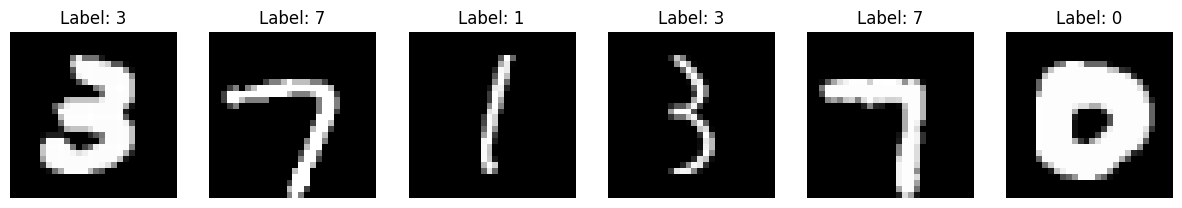

In [ ]:
# Carregando o dataset MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Visualizando algumas imagens do dataset MNIST
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axs[i].imshow(example_data[i][0], cmap='gray')
    axs[i].set_title(f'Label: {example_targets[i].item()}')
    axs[i].axis('off')
plt.show()


## Definindo a Arquitetura do VAE
**Codificador (Encoder):**

O codificador (encoder) comprime a imagem de entrada em uma distribuição latente. Vamos definir o codificador com uma rede neural simples:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  # [batch_size, 32, 14, 14]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # [batch_size, 64, 7, 7]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # [batch_size, 128, 3, 3]
        self.flatten = nn.Flatten()  # Flatten para [batch_size, 128*3*3]
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

**Decodificador (Decoder):**

O decodificador (decoder) reconstrói a imagem a partir da distribuição latente. Vamos definir o decodificador com uma rede neural simples:

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # [batch_size, 64, 6, 6]
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0)  # [batch_size, 32, 14, 14]
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # [batch_size, 1, 28, 28]

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 128, 3, 3)  # Redimensionar para [batch_size, 128, 3, 3]
        h = torch.relu(self.deconv1(h))
        h = torch.relu(self.deconv2(h))
        x_reconstructed = torch.sigmoid(self.deconv3(h))
        return x_reconstructed

**Definindo o VAE:**

Vamos combinar o codificador e o decodificador para formar o VAE:

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


**Definindo a Função de Custo (Loss Function):**

A função de custo do VAE é composta pela perda de reconstrução e pela perda de regularização (divergência KL).

In [ ]:
def loss_function(x_reconstructed, x, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

## Treinando o VAE
Vamos treinar o VAE usando o dataset MNIST.

**Inicialização do Modelo e Otimizador**


In [ ]:
input_channels = 1  # MNIST tem imagens em escala de cinza
latent_dim = 20
lr = 0.001

model = VAE(input_channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

**Loop de treinamento**

In [ ]:
from tqdm import tqdm

# Treinando o VAE
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = model(data)
        loss = loss_function(x_reconstructed, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}")


938it [00:12, 76.08it/s]


Epoch [1/10], Loss: 97.3696


938it [00:11, 78.32it/s]


Epoch [2/10], Loss: 90.2272


938it [00:12, 77.98it/s]


Epoch [3/10], Loss: 88.2100


938it [00:12, 77.81it/s]


Epoch [4/10], Loss: 87.0994


938it [00:12, 78.05it/s]


Epoch [5/10], Loss: 86.3322


938it [00:12, 74.57it/s]


Epoch [6/10], Loss: 85.7499


938it [00:13, 70.20it/s]


Epoch [7/10], Loss: 85.2467


938it [00:12, 75.27it/s]


Epoch [8/10], Loss: 84.8509


938it [00:12, 72.87it/s]


Epoch [9/10], Loss: 84.5122


938it [00:12, 75.94it/s]

Epoch [10/10], Loss: 84.2470


## Gerando Novas Imagens
Após o treinamento, podemos gerar novas imagens amostrando do espaço latente.

Amostrando do Espaço Latente

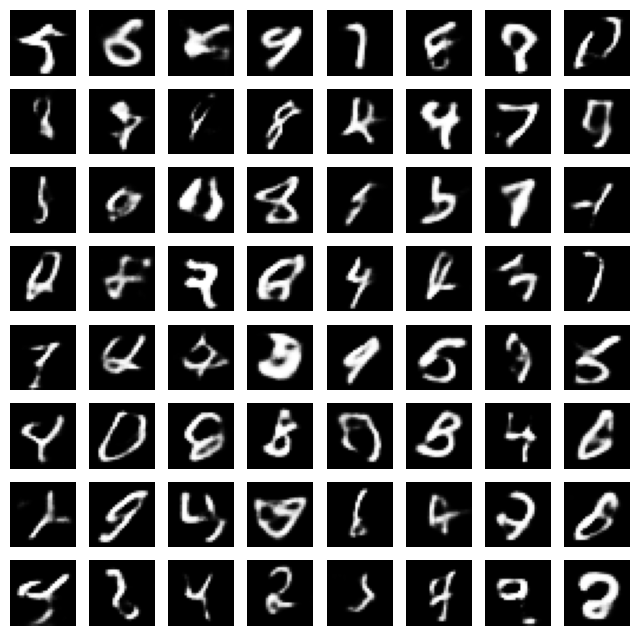

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_images = model.decoder(z).cpu()

    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generated_images[i].view(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

## Construindo um CVAE

In [ ]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_channels, num_classes, latent_dim):
        super(ConditionalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels + num_classes, 32, kernel_size=4, stride=2, padding=1)  # [batch_size, 32, 14, 14]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # [batch_size, 64, 7, 7]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # [batch_size, 128, 3, 3]
        self.flatten = nn.Flatten()  # Flatten para [batch_size, 128*3*3]
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x, labels):
        labels = labels.view(labels.size(0), labels.size(1), 1, 1)
        labels = labels.expand(labels.size(0), labels.size(1), x.size(2), x.size(3))
        x = torch.cat((x, labels), dim=1) # concatenando as labels
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [ ]:
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, num_classes, output_channels):
        super(ConditionalDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, 128 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # [batch_size, 64, 6, 6]
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0)  # [batch_size, 32, 14, 14]
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # [batch_size, 1, 28, 28]

    def forward(self, z, labels):
        z = torch.cat((z, labels), dim=1) # concatenando as labels
        h = self.fc(z)
        h = h.view(-1, 128, 3, 3)  # Redimensionar para [batch_size, 128, 3, 3]
        h = torch.relu(self.deconv1(h))
        h = torch.relu(self.deconv2(h))
        x_reconstructed = torch.sigmoid(self.deconv3(h))
        return x_reconstructed

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_channels, num_classes, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_channels, num_classes, latent_dim)
        self.decoder = ConditionalDecoder(latent_dim, num_classes, input_channels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z, labels)
        return x_reconstructed, mu, logvar

In [ ]:
def loss_function(x_reconstructed, x, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

In [ ]:
# Inicializando o modelo e o otimizador
input_channels = 1  # MNIST tem imagens em escala de cinza
num_classes = 10  # MNIST tem 10 classes (0-9)
latent_dim = 20
lr = 0.001
model = CVAE(input_channels, num_classes, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Convertendo rótulos em one-hot encoding
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].to(device)

In [ ]:
# Loop de treinamento
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = one_hot(labels, num_classes)
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = model(data, labels)

        # Verifique as dimensões dos tensores
        assert x_reconstructed.shape == data.shape, f"Shape mismatch: {x_reconstructed.shape} vs {data.shape}"

        loss = loss_function(x_reconstructed, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch [1/10], Loss: 134.3341
Epoch [2/10], Loss: 90.8321
Epoch [3/10], Loss: 87.3204
Epoch [4/10], Loss: 85.7575
Epoch [5/10], Loss: 84.7911
Epoch [6/10], Loss: 84.0355
Epoch [7/10], Loss: 83.5561
Epoch [8/10], Loss: 83.0970
Epoch [9/10], Loss: 82.7453
Epoch [10/10], Loss: 82.4187


NameError: name 'torch' is not defined

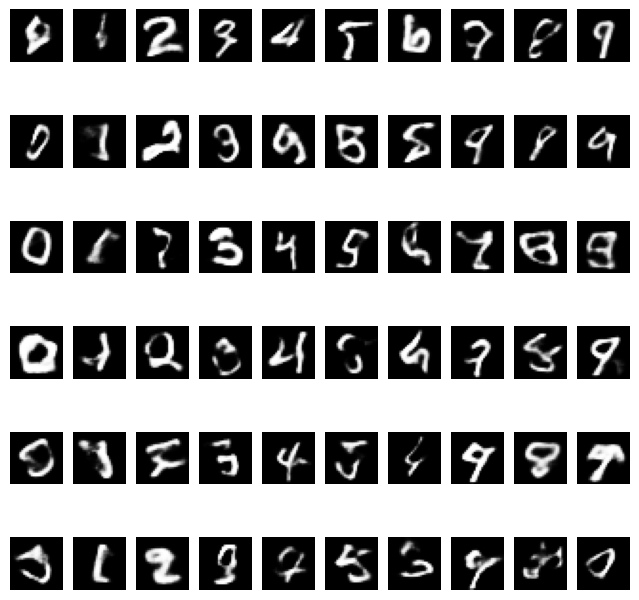

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(60, latent_dim).to(device) # vetor aleatorio
    labels = torch.arange(0, 10).repeat(6, 1).view(-1) # gerando os condicionais de 0 a 10 6 vezes
    labels_one_hot = one_hot(labels, num_classes).to(device)
    generated_images = model.decoder(z, labels_one_hot).cpu()

    fig, axs = plt.subplots(6, 10, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generated_images[i].view(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()